In [1]:
from ndslib.config import jupyter_startup
jupyter_startup()

(skimage)=
# Image processing

Images are used as data in many different contexts. For one, many different
research fields use imaging instruments to study a variety of natural phenomena:
everything from telescopes that image faraway galaxies, to powerful microscopes
that can image individual molecular components of a living cell. But images are
also used in commercial applications of data science. For example, in sorting
through the photographs that we upload into social media or photo sharing
services. Computer vision, another name for some of the advanced applications of
image processing, has been used for a long time in things like quality control
of printed circuit boards but is also highly used in many newfangled
technologies, such as in providing driverless cars with the input they need to
decide where to go.

Neuroscience research has also been fascinated with images for almost as long as it has existed as a science. Santiago Ramón y Cajal, a Spanish neuroanatomist who lived around the turn of the 20th century, and who was arguably one of the first modern neuroscientists, conducted a large part of his research by peering at brain tissue through a microscope and making (often strikingly beautiful!) pictures of what he saw (you can see some of them on [the Marginalian website](https://www.themarginalian.org/2017/02/23/beautiful-brain-santiago-ramon-y-cajal/). One could argue that we haven't made much progress, judging from the fact that a lot of contemporary research in neuroscience aims to do something very similar. More optimistically, we could say that the rapid development of imaging instruments and experimental techniques that have happened even just in the last few years has vaulted the field forward to create imaging data that show the activity of hundreds and even thousands of neurons simultaneously, while animals are performing a specific behavior. It's still images, but they contain much more information than what Cajal had under his microscope. And we have fast computers and modern algorithms to analyze the data with, so maybe there is some progress.

```{eval-rst}
.. index::
   single: Ramon y Cajal, Santiago
```


Neuroimaging is of course all about images and the fundamental type of data that
most neuroimaging researchers use are images of brains. In this section, we'll
give a broad introduction to image processing that will survey a wide range of
different kinds of operations that you can do with images. We'll focus on the
open-source [Scikit Image](https://scikit-image.org/) library and the operations
that are implemented within this library. One of the advantages of using Scikit
Image is that it is built as a domain-agnostic tool. Thus, instead of focusing
on one particular application domain, the library exemplifies the
interdisciplinary and quantitative nature of image processing by collecting
together algorithms that have been developed in many different contexts.

Overall, the purpose of this chapter is to develop an intuition for the kind of
things that you might think about when you are doing image processing. In the
next sections, we will zoom in and dissect in more detail two kinds of
operations: image segmentation and image registration. These are particularly
common in the analysis of neuroimaging data and a detailed understanding of these
operations should serve you well, even if you ultimately use specialized
off-the-shelf software tools for these operations, rather than implementing them
yourself.

## Images are arrays

As you saw earlier in this book, data from neuroimaging experiments can be
represented as Numpy arrays. That is also true of images in general. So, what is
the difference between an image and another kind of array? One thing that
distinguishes images from other kinds of data is that spatial relationships are
crucially important for the analysis of images. That is because neighboring
parts of the image usually represent objects that are near each other in the
physical world as well. As we'll see below, many kinds of image-processing
algorithms use these neighborhood relationships. Conversely, in some cases,
these neighborhood relationships induce constraints on the operations one can do
with the images because we'd like to keep these neighborhood relationships
constant even if we put the image through various transformations. This too will
come up when we discuss image processing methods that change the content of
images.

## Images can have two dimensions or more

We typically think of images as having two dimensions, because when we look at
images, we are usually viewing them on a two-dimensional surface: on the screen
of a computer or a page. But some kinds of images have more than one
dimension. For example, in most cases where we are analyzing brain images, we
are interested in the full three-dimensional image of the brain. This means that
brain images are usually (at least) three-dimensional. Again, under our
definition of an image, this is fine. So long as the spatial relationships are
meaningful and important in the analysis, it is fine that they extend over more
than two dimensions.

## Images can have other "special" dimensions

In some cases, we would like for there to be ways to represent several different
properties of one location in the image. One common example of this is that
images containing color need to specify three different values in each pixel for
the color to be defined for that pixel. Typically, these three values will
represent the intensities of red, green, and blue in the location. When we
organize our data with a channel dimension the order of the channels is not
necessarily meaningful -- you can represent color images as RGB, as BGR, or even
as GRB. So long as you use a consistent order, the meaning of the image doesn't
change. Another interesting case of a special dimension is the case in which
images of the same object were taken as a series in time. In this case, one
dimension of the image can be time. In contrast to channels, time is similar to
the spatial organization of the image in that the order of the images along this
axis does matter. The fact that they were acquired in time makes the different
samples of the brain amenable to a particular set of analysis methods called
time-series analysis, which is beyond the scope of our book.

To see this more clearly, let's get started with Scikit Image. The library
includes a sub-module that provides access to some image datasets that are used
for testing and demonstrating the library's functionality. For example, one of
the datasets is called `astronaut`. Let's load it and explore its properties.

```{eval-rst}
.. index::
   single: RGB
```

```{eval-rst}
.. index::
   single: Scikit Image
```

In [2]:
import skimage
img = skimage.data.astronaut()
print(img.shape)
print(img.dtype)

(512, 512, 3)
uint8


The astronaut image is two-dimensional, but the array has three dimensions: this
is because it has 512 by 512 pixels and each pixel stores three numbers
corresponding to the R, G, and B color channels. These numbers are stored as
8-bit unsigned integers. This means that in each channel within each pixel the
intensity of luminance at that location and that color is stored as a number
between 0 (no luminance in that color at all) to 255 (full luminance at that
color). Let's use Matplotlib to visualize the contents of this image. In
addition to the `matshow` function that you saw in {numref}`viz`, Matplotlib
implements an `imshow` function. One of the main differences between these is
that `imshow` knows that images sometimes have color channels, and knows how to
properly handle images that have three dimensions, such as this one. We also
highlight two specific pixels in the image, by plotting white circular markers
on top of them.

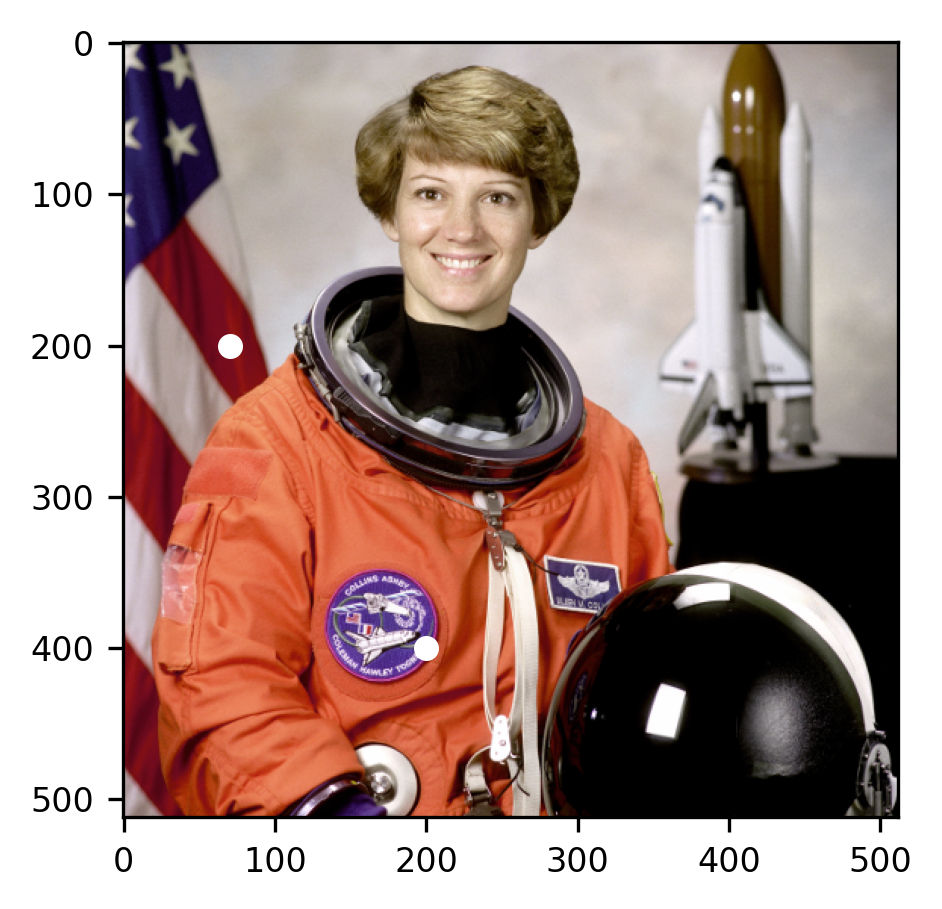

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(img)
ax.plot(70, 200, marker='o', markersize=5, color="white")
p = ax.plot(200, 400, marker='o', markersize=5, color="white")

```{eval-rst}
.. index::
   single: Collins, Eileen
```

It turns out that this is a picture of Eileen Collins, who was the first woman
to pilot a space shuttle and to become the Commander of a space shuttle. Apart
from serving as a reminder of her inspiring story, and of the marvelous
achievements of science, the image also serves as a good basis for algorithms
that analyze different aspects of images. For example, many image processing
algorithms are designed to detect faces in images (because faces are a
particularly interesting object for many applications of image processing), and
this image contains a face.

Looking at specific pixels in the image, we see what it means for there to be a
representation of color in the last dimension. Let's look at the two pixels that
were highlighted in the image. The pixel at `img[200, 70]` is immediately behind
Commander Collins' right shoulder inside one of the red stripes in the US flag.
The luminance values of that pixel are relatively high for the first (R=red)
channel and lower for the other two. That's the reason this pixel appears red.
The pixel `img[400, 200]` is inside a patch on her space suit and is instead
relatively highly weighted on the last (B=blue) channel. That is why it appears
blue.

In [4]:
print(img[200, 70])
print(img[400, 200])

[122  14  29]
[ 79  36 126]


## Operations with images

Because of the information that is stored in the structure of image data, they
are particularly amenable to certain kinds of operations. We will briefly look
at a few of these here, and then look at a couple of these operations in depth
in the next

### Filtering

```{eval-rst}
.. index::
   single: Filtering
```

Filters are operations that take an image as an input and produce another image
as the output. As their name suggests, the result of this kind of operation
often retains some properties of the original image, while throwing away other
properties of the image. For example, we can filter out the color, turning the
image into a gray-scale image:

In [5]:
from skimage.color import rgb2gray
gray_img = rgb2gray(img)
print(gray_img.shape)

(512, 512)


As you can see, this operation retains the pixel dimensions, but reduces the
number of values in each pixel to one, instead of the three-channel values that
used to be there. In each pixel, the values in the different channels are
combined using an equation that accounts for the sensitivity of human vision to
changes in luminance in the different colors. The `imshow` function understands
that because the image does not have a third dimension it should be displayed as
a pseudocolor image. Here, it is displayed using a gray-scale colormap. High
values of gray are mapped to bright numbers and low values are mapped to dark
colors.

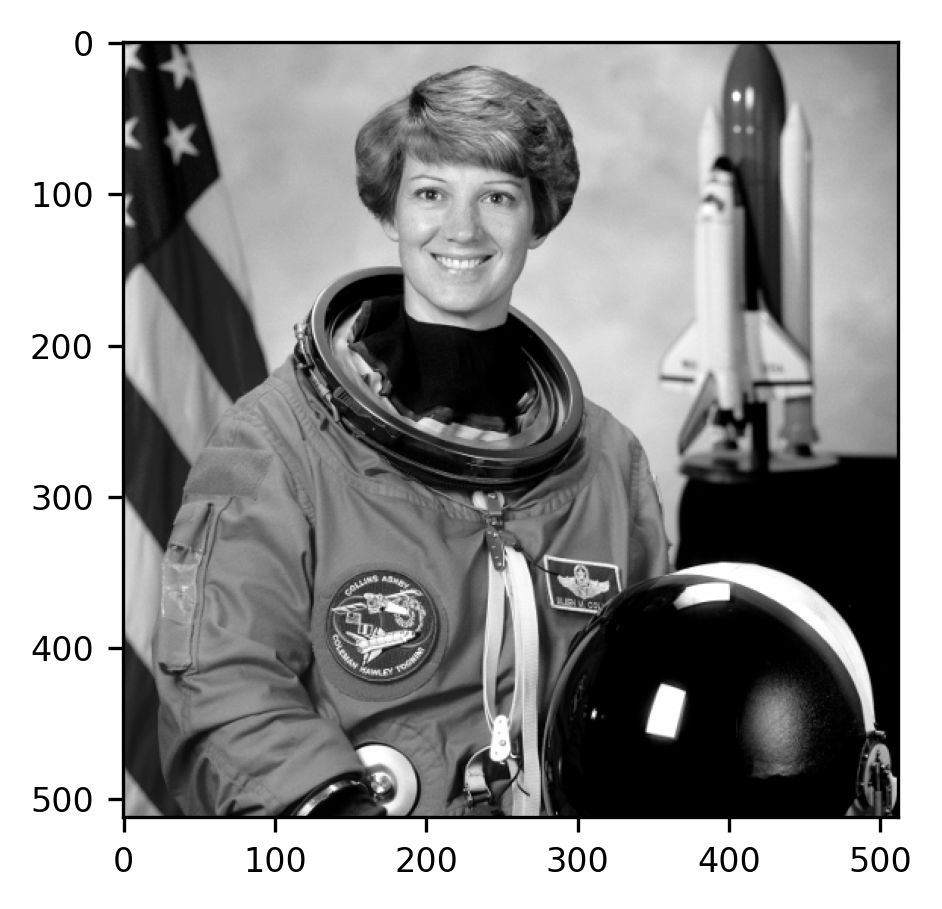

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.imshow(gray_img)

(skimage_ex1)=
#### Exercise

What are the values of the pixels that were highlighted above in the gray-scale image? Are these values high or low? Why do you think they get converted in this way? Take a look at the documentation for `rgb2gray` to get a hint.

(convolution)=
### Convolution filters

```{eval-rst}
.. index::
   single: Convolution
```

There are many other kinds of filters that you can apply to an image. A large
family of filters involves an operation called _convolution_. We'll explain this
operation here in some detail. This is both because understanding how a
convolution works will help you understand some of the basics of image
processing much better, but also because we will come back to this operation
much later in the book when we discuss a family of machine learning algorithms
called convolutional neural networks, which are particularly powerful for
analyzing image data (see {numref}`dl`).

The essence of a convolution is that the intensity of each pixel in the image is
replaced by a weighted sum of the neighborhood of that pixel. In the simplest
case, the weight of each neighbor in the neighborhood is the same number, but
things get a lot more interesting when the weights are not equal for all
neighbors. The function that describes the weights that are applied to each
neighbor in the neighborhood around the pixel is sometimes called a "filter" or
also a "kernel"

Let's make this explanation a bit more concrete by looking at a simple example.
Because images are arrays, we can create a small array and work with it, before
interacting with more complicated images. To make things very concrete, we will
use a function that we have created that takes an array and displays it (just
like `imshow` or `matshow`), but also adds a numeral that displays the value of
the pixel in that location:

In [7]:
from ndslib.viz import imshow_with_annot
import numpy as np

Let's start with a very small array of 4 by 5 pixels, which will serve as our
example image for now. Because the pixels do not have three RGB values in them,
`imshow` displays them as values of gray, where lower values are darker and the
higher values are brighter:

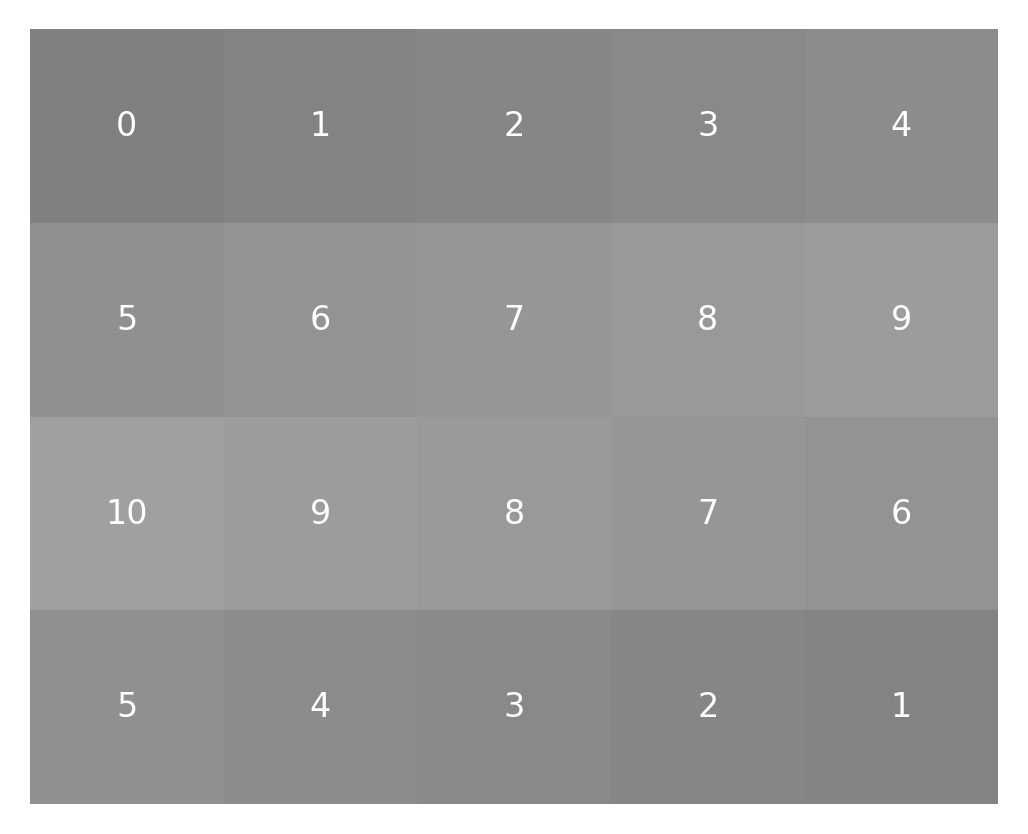

In [8]:
small_image = np.concatenate([np.arange(10), np.arange(10, 0, -1)]).reshape((4, 5))
imshow_with_annot(small_image)

A convolution takes this image as input and produces an output with a similar
size, but different values. To demonstrate the convolution filter operation we
will start by creating the array that will eventually hold the results of this
filter operation. Then, we will start filling it up with the results of the
convolution as we go along:

In [9]:
small_result = np.zeros(small_image.shape)

The values that will eventually be placed in this result array are based on a
sum of a little neighborhood around each pixel weighted by the kernel function.
For our example, let's design a little 3-by-3 pixel kernel with values in it:

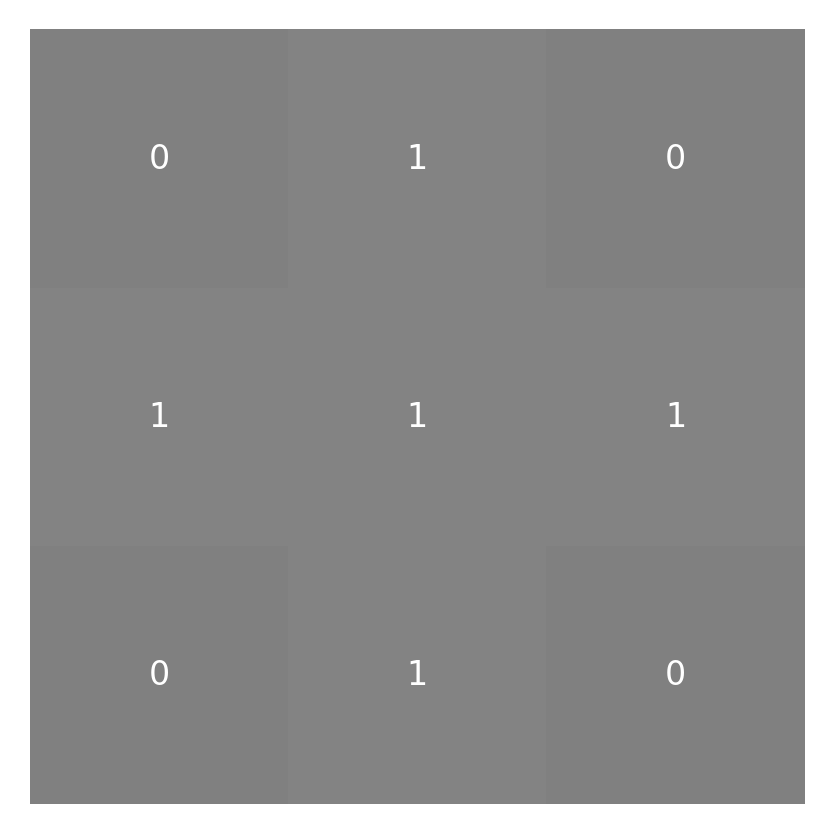

In [10]:
small_kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
imshow_with_annot(small_kernel)

Before we can get to convolving the kernel and the image ("convolving" is the
verb form of "convolution"), we have to deal with the fact that not all of the
pixels have the same number of neighbors surrounding them. This is because some
of the pixels are right on the edge of the image. One way to deal with that is
to pad the image all around with zeros:

In [11]:
padded_small_image = np.pad(small_image, 1)

This adds another layer of pixels all around the image:

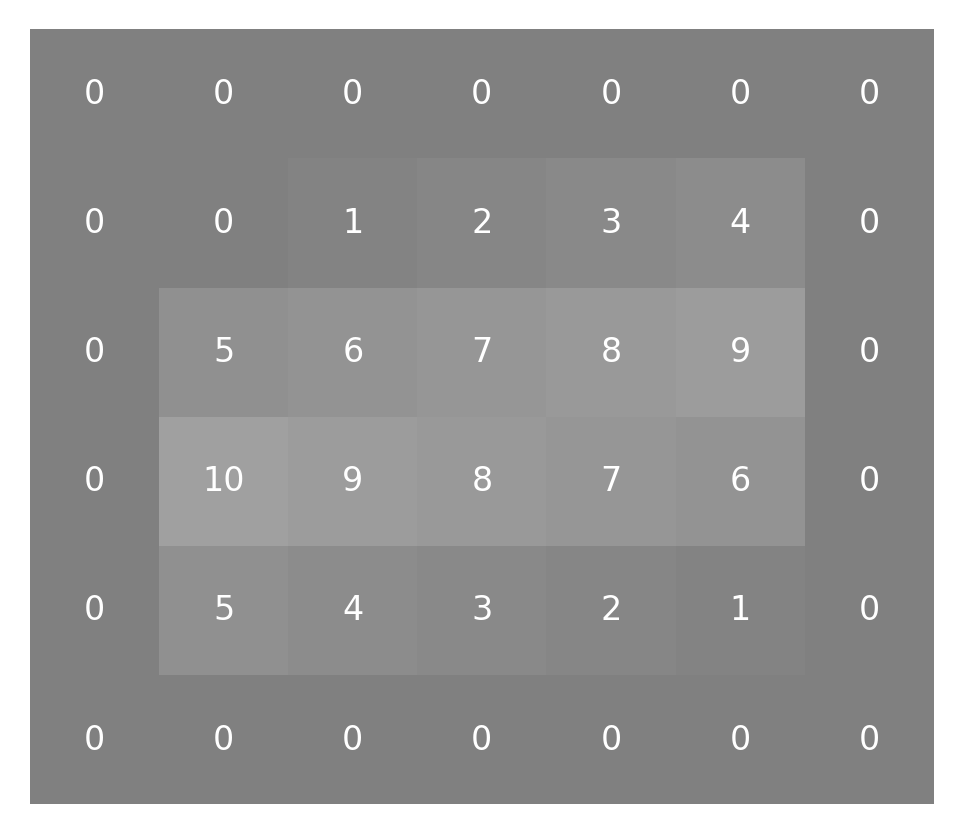

In [12]:
imshow_with_annot(padded_small_image)

Having done that, we can start doing our convolution. We start with the pixel
that is in the top left part of the image. Having added a pad of 1 pixel all
around the image, the pixel that used to be in coordinate `[0,0]` is now in
coordinate `[1,1]` instead. To produce a weighted sum of its neighbors, we first
take the sub-array `small_image[0:3, 0:3]` and multiply it by the kernel. Recall
from {numref}`numpy` that the multiplication of two Numpy arrays of the same
size (here 3 elements by 3 elements) with the `*` operator produces a result of
the same size, where each element is the product of the elements in that
location in the original arrays. Or, in other words, this operator produces an
element-by-element product of the two arrays.

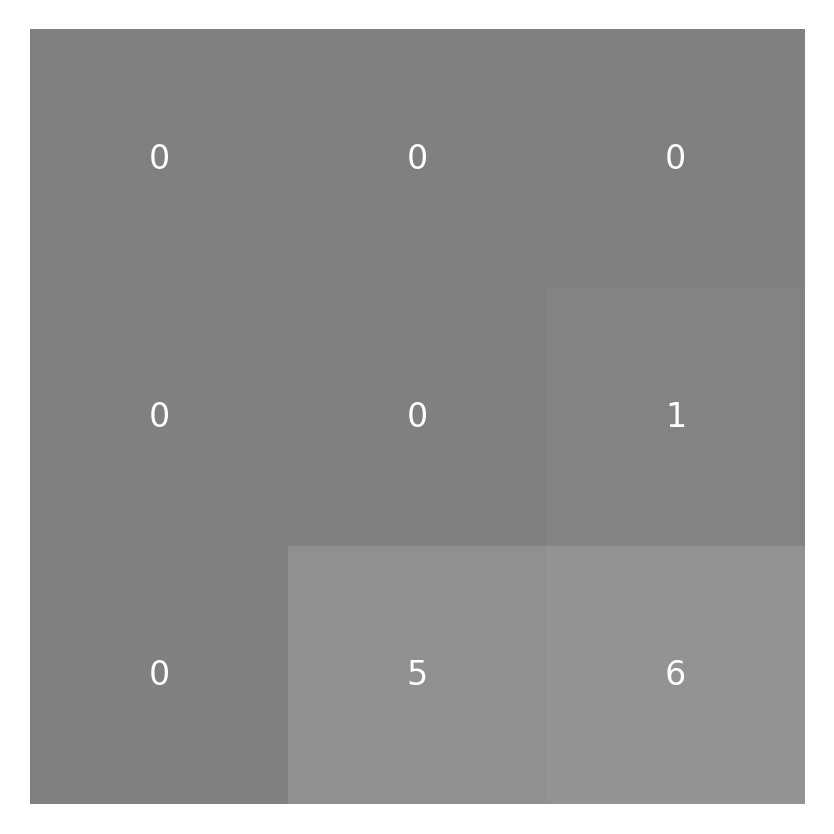

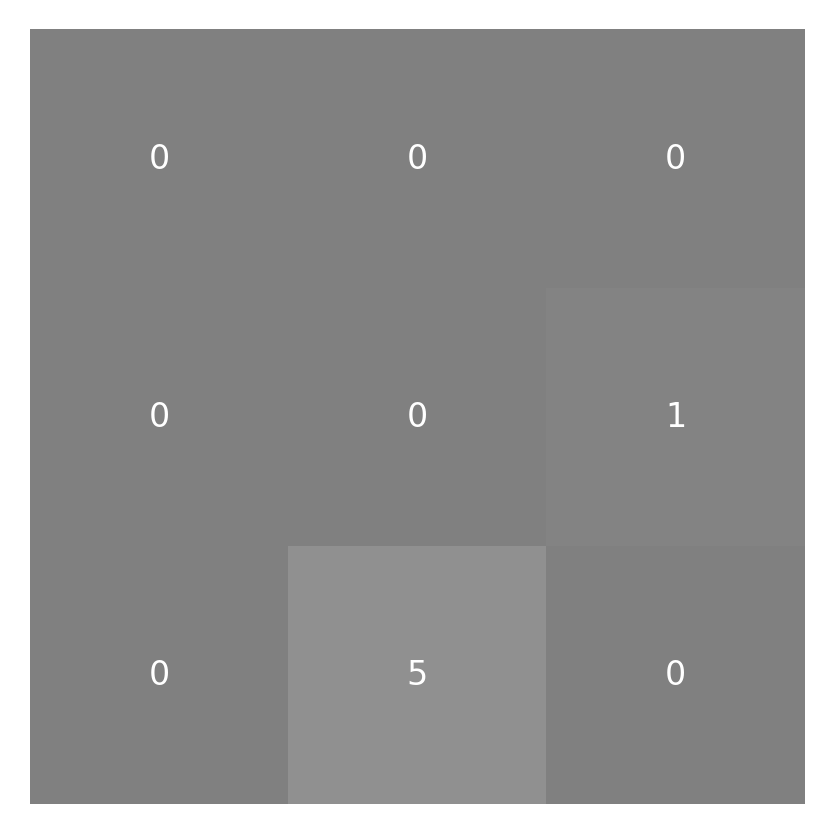

In [13]:
neighborhood = padded_small_image[:3, :3]
weighted_neighborhood = neighborhood * small_kernel
imshow_with_annot(neighborhood)
imshow_with_annot(weighted_neighborhood)

To finish the convolution operation we want the weighted sum, so we take the
values of this `weighted_neighborhood` and sum them up:

In [14]:
conv_pixel = np.sum(weighted_neighborhood)

This will be the result that will be placed in the top left corner of the result.
We have not zero-padded the result, so that pixel is still in coordinate `[0, 0]` in
the result array:

In [15]:
small_result[0, 0] = conv_pixel

We can repeat this same sequence of operations for the next pixel: the second
pixel in the top row of the image:

In [16]:
neighborhood = small_image[:3, 1:4]
weighted_neighborhood = neighborhood * small_kernel
conv_pixel = np.sum(weighted_neighborhood)
small_result[0, 1] = conv_pixel

To complete the convolution, we would keep on moving like this pixel by pixel in
the first row and then move on to the second row, completing each pixel in the
second row and so on, until we have gone through all of the pixels in the
original image. We can generalize this to write a bit of code that would repeat
this operation over every pixel in the original image, filling up the result
along the way:

In [17]:
for ii in range(small_result.shape[0]):
    for jj in range(small_result.shape[1]):
        neighborhood = padded_small_image[ii:ii+3, jj:jj+3]
        weighted_neighborhood = neighborhood * small_kernel
        conv_pixel = np.sum(weighted_neighborhood)
        small_result[ii, jj] = conv_pixel

After completing this operation, the result is an array of the same size

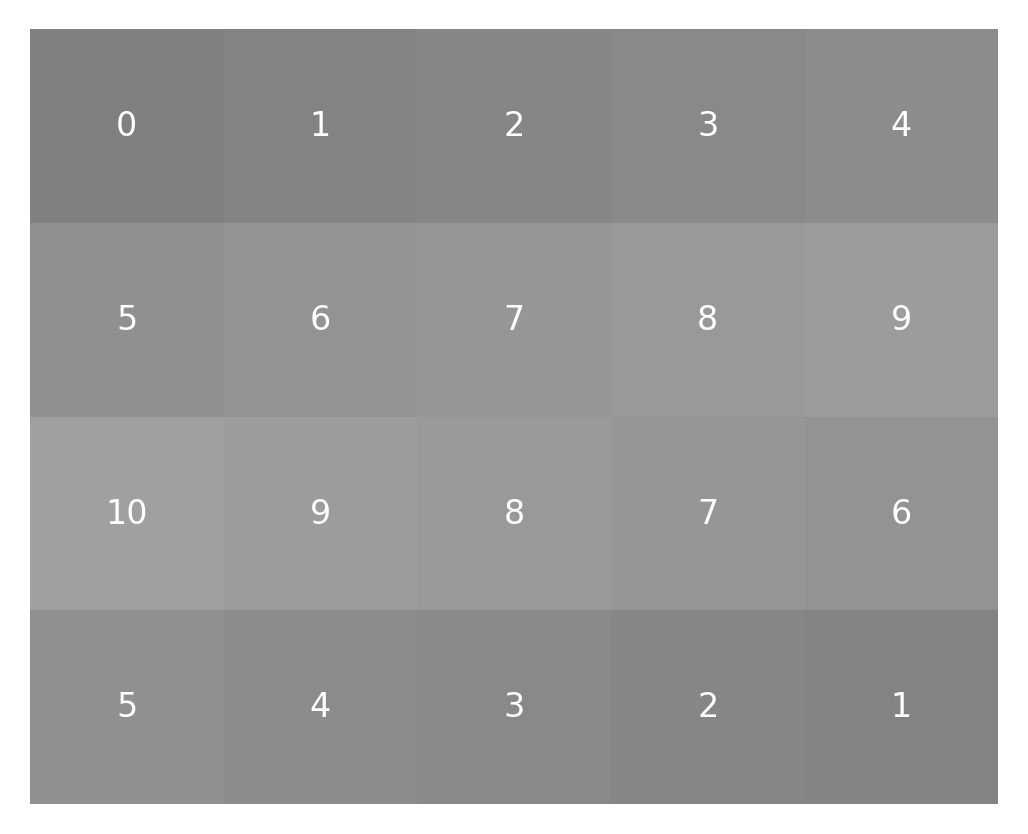

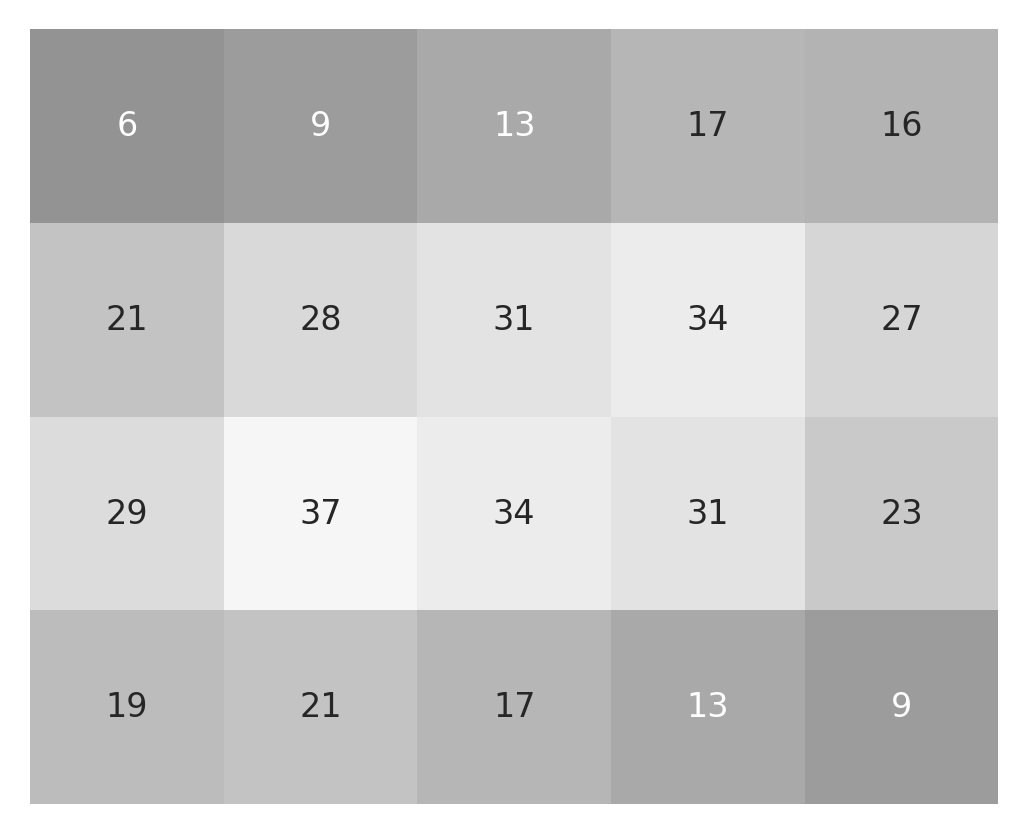

In [18]:
imshow_with_annot(small_image)
imshow_with_annot(small_result)

We can expand this idea to a slightly more realistic example, based on the
astronaut image that you saw above. One filter which is commonly used in image
processing is a Gaussian blur filter. Here, the kernel is a small Gaussian bump:
in each pixel of the original image, we add in a bit of the value of the pixels
in its neighborhood. The further the neighbor is, the less of that neighbor's
value gets added in. This is useful if you need to blur the image a bit. For
example, if you want to pool over neighboring pixels to overcome local noise
patterns. We've implemented a function that generates a Gaussian kernel:

```{eval-rst}
.. index::
   single: Gaussian filter
```

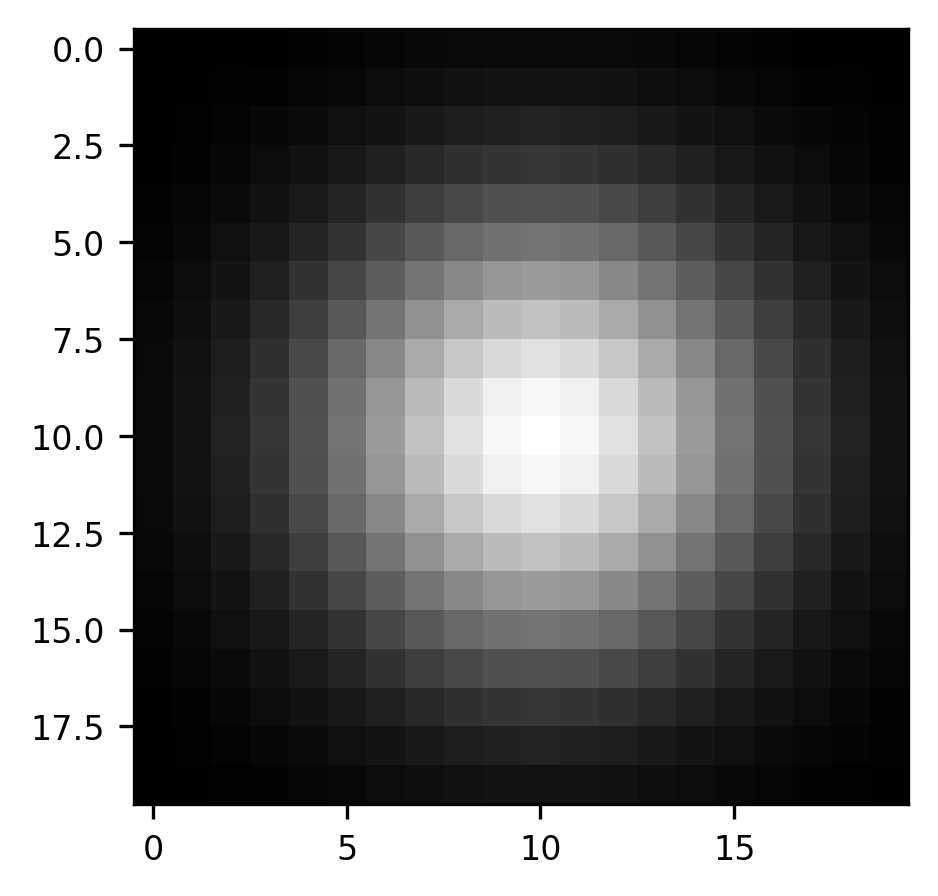

In [19]:
from ndslib.image import gaussian_kernel

kernel = gaussian_kernel()

fig, ax = plt.subplots()
im = ax.imshow(kernel, cmap="gray")

As before, we begin by creating what will be the final result, an empty array
with the same size as the array of the image that we are interested in
convolving with our kernel

In [20]:
result = np.zeros(gray_img.shape)

Because the kernel is a bit larger in this case, we will need to pad the image
around its edges with a margin that is a bit larger than before. To get the
kernel right on top of the pixel that is on the edge of the image, we need the
padding to extend half of the size of the kernel in each direction:

In [21]:
padded_gray_img = np.pad(gray_img, int(kernel.shape[0] / 2))

Once we do that, the code looks remarkably similar to the code that you saw
before, the main difference being that the neighborhood in each round is now
defined to be larger, extending to the size of the kernel.

In [22]:
for ii in range(result.shape[0]):
    for jj in range(result.shape[1]):
        neighborhood = padded_gray_img[ii:ii+kernel.shape[0], jj:jj+kernel.shape[1]]
        weighted_neighborhood = neighborhood * kernel
        conv_pixel = np.sum(weighted_neighborhood)
        result[ii, jj] = conv_pixel

The outcome is again an image with a size that is identical to the size of the
original input image. In this case, it is instructive to compare the original
image with the filtered image:

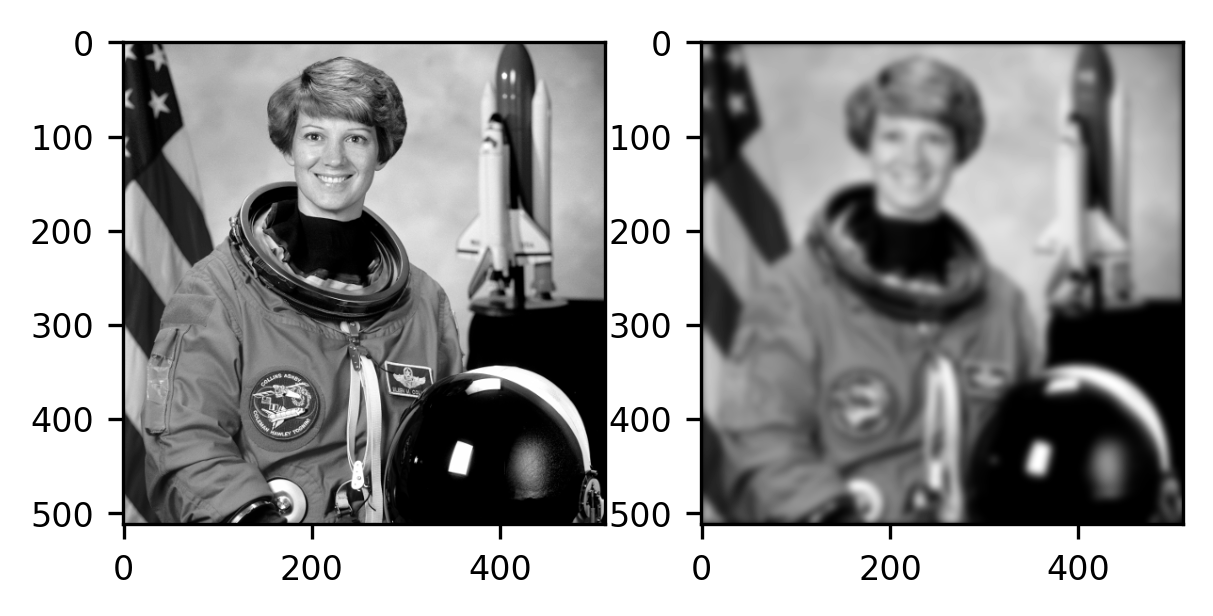

In [23]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(gray_img, cmap="gray")
im = ax[1].imshow(result, cmap="gray")

As you can see, the image on the right (filtered) is blurrier than the image on
the left (the original). Intuitively, this is because each pixel is now more
similar to the pixels that are its neighbors. For example, the boundaries
between parts of the image that are very dark (for example, the parts of the
image that contain Cmdr Collins' eye) and bright parts (the skin surrounding the
eye) have become fuzzier, and this transition is now more gradual. Each pixel
resembles its neighbors more because they have been mixed through the process of
convolution.

(skimage_ex2)=
#### Exercise

MRI data of brains contain three-dimensional images of brains. Write the code that you would need to convolve an MRI dataset with a three-dimensional kernel.

### Convolution filters in Scikit Image

Scikit Image implements a variety of standard convolutional filters. Using the
implementation in Scikit Image is generally easier because it saves you the
need to keep track of issues like padding and indexing into the array. In cases
where the code can be speeded up using various tricks, these have been
implemented, so that your code will also run faster. In other words, if Scikit Image
implements it, it would be a waste of your time to re-implement it. For example:

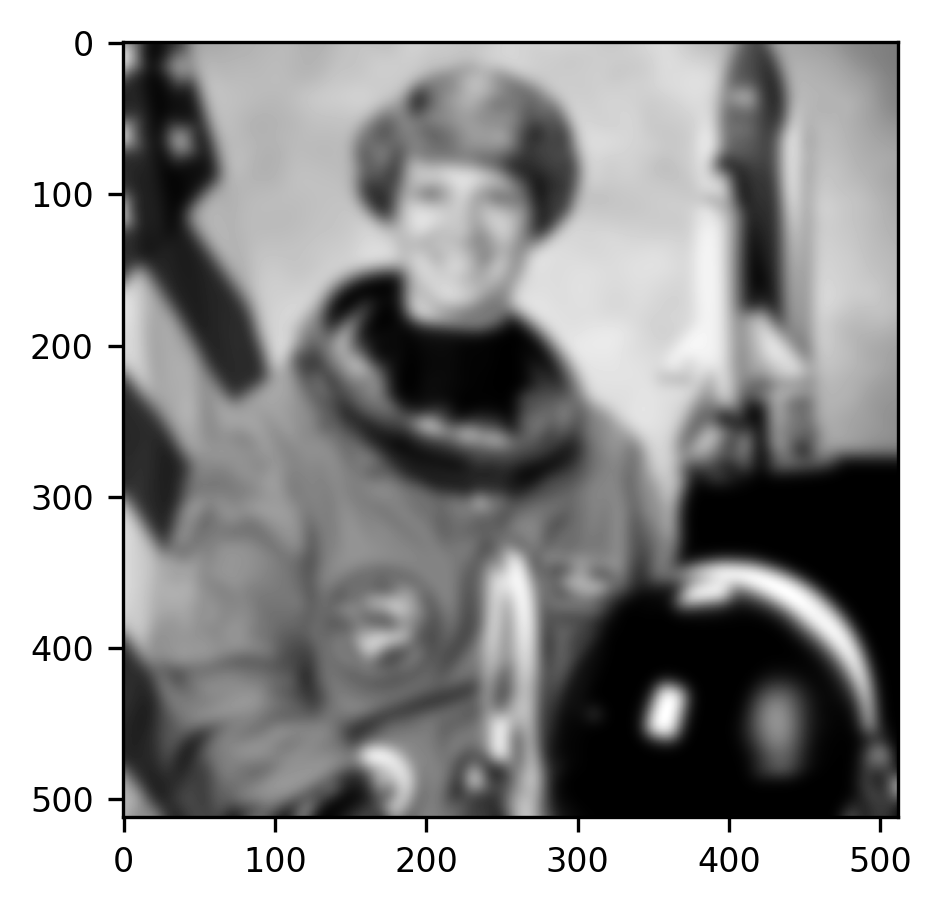

In [24]:
from skimage.filters import gaussian
fig, ax = plt.subplots()
im = ax.imshow(gaussian(gray_img, sigma=5))

The "sigma" parameter that we input into the function changes the spread of the
Gaussian filter that is used. To get a feel for what this parameter does, you
can try changing its value to larger or smaller numbers.

One of the advantages of many of the filters implemented in Scikit Image is that
they can operate on more than the two dimensions of a photograph. For example,
the same function works just as well on three-dimensional scientific data, such
as brain images. That means that the work that you did in the exercise above is
done for you within the call to this function. To demonstrate that, let's look
at a single volume from a BOLD series:

In [25]:
from ndslib.data import load_data
brain = load_data("bold_volume")

We apply the same Gaussian filter to this data and then compare the original
data with the Gaussian-smoothed data.

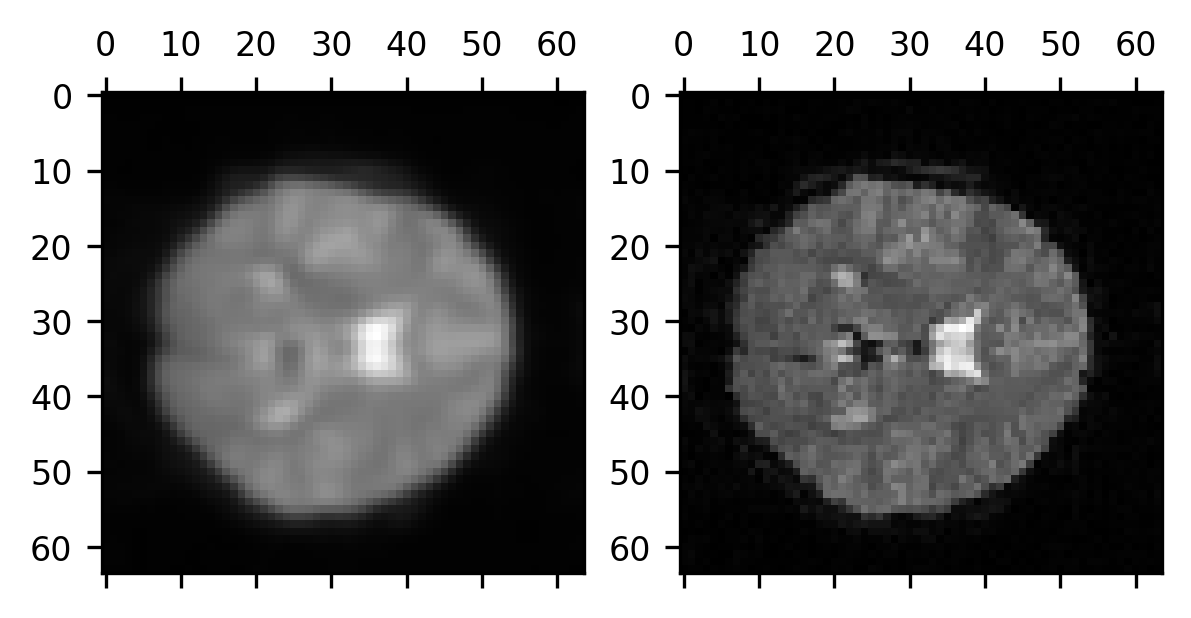

In [26]:
smoothed_brain = gaussian(brain, sigma=1)
fig, ax = plt.subplots(1, 2)
ax[0].matshow(smoothed_brain[:, :, 10])
im = ax[1].matshow(brain[:, :, 10])

Notice that we are applying the smoothing to the three-dimensional volume of
data, so each voxel receives some information not only from the voxels
surrounding it within the plane of the 2-dimensional image we see here but also
from its neighbors in the other slices immediately adjacent to this slice.


(sobel_exercise)=
#### Exercise

Scikit image implements many other filters. The effect of the filters is not always to smooth the data. In some cases, filters are designed to emphasize certain features of the data. One of the filters that emphasize features is called a Sobel filter. Try running `skimage.filters.sobel` on the two images that you have seen here: the gray-scale image of Comdr Collins and the brain volume. What is the Sobel filter emphasizing? Try running `skimage.filters.sobel_h` and `skimage.filters.sobel_v` on the 2D grayscale image. What do these filters emphasize? What do you think 'h' and 'v' stand for? Why wouldn't these functions work on the brain image?

(morphology)=
### Morphological operations

```{eval-rst}
.. index::
   single: Morphology
```

Another set of filtering operations -- operations that take images as their
input and produce images as their outputs -- pay specific attention to the
shapes that appear in the image. These are known as *morphological operations*
(the word "morphology" is derived from the Greek word for shape). Instead of a
kernel, morphological operations use a "structuring element". These are also
small arrays that are used to process each pixel and its neighborhood, but there
are a few ways in which structuring elements differ from kernels: first, they
are binary containing only 1s and 0s. Instead of multiplying the structuring
element with the region surrounding each pixel, in morphological operations, the
structuring element is compared to the contents of this neighborhood in a
variety of different ways. For example, in a morphological *dilation*, each
pixel in the image gets the maximal value of the pixels within the regions
covered by 1's in the structuring element. In morphological *erosion*, on the
other hand, each pixel gets the minimal value of the pixels covered by 1's in
the structuring element. Per default, the structuring element that is used in
Scikit Image is exactly the kernel that we used to demonstrate convolution in
{numref}`convolution`: a cross-shaped structure with 1's along the horizontal
and vertical pixels and 0's in the corners. It turns out that this is a good
structuring element to perform useful and interesting image processing
operations even just with these two operations. Let's look at an example of
this. For now, we will look at this using a toy example, and we'll come back to
look at its use with brain data in {numref}`segmentation`. The Shepp-Logan
phantom is an image that was created to emulate the physical properties of a
human brain, as the basis for developing image processing algorithms for brain
imaging methods. It contains a 400-by-400 pixel array of grayscale values that
include a skull (brighter than other parts) and ventricles (darker than other
parts), as well as some internal structure (white matter, gray matter, and
sub-cortical nuclei).

```{eval-rst}
.. index::
   single: Shepp-Logan phantom
```

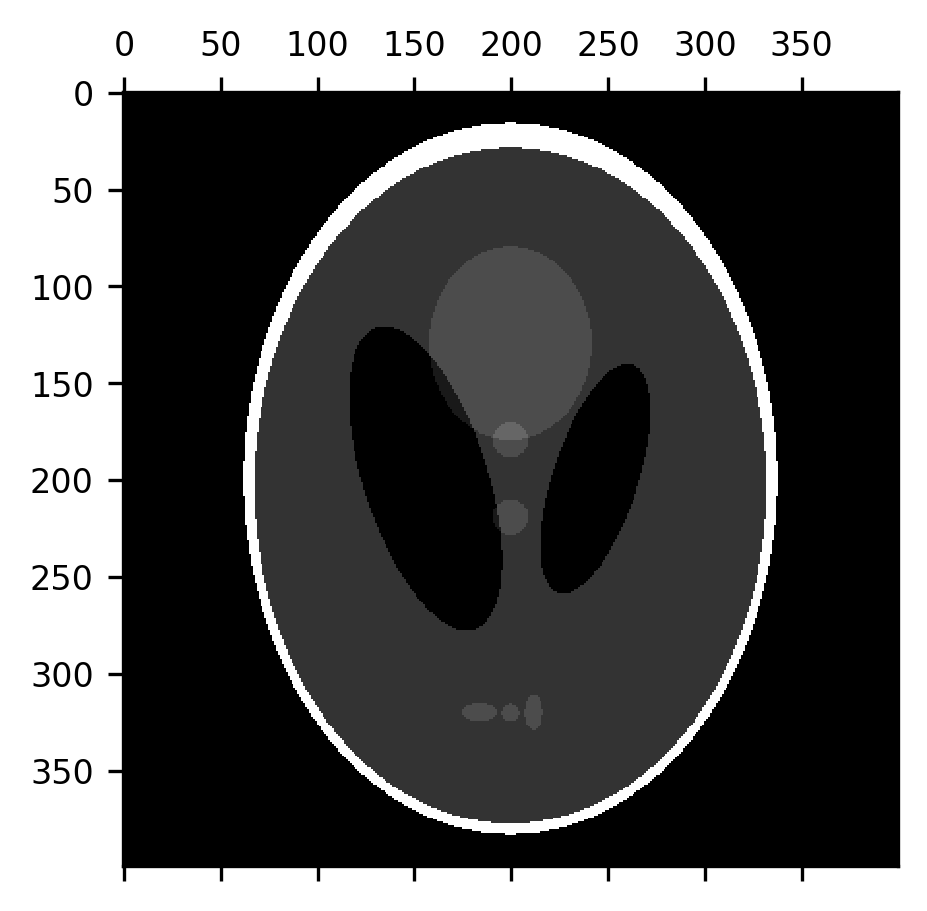

In [27]:
shepp_logan = skimage.data.shepp_logan_phantom()
fig, ax = plt.subplots()
im = ax.matshow(shepp_logan)

One of the things that erosion operations do rather effectively is take care of
certain kinds of noise in the image. For example, "salt-and-pepper noise" that
sometimes appears in images takes the form of pixels that are randomly flipped
to completely black or completely white. Let's add some of this kind of noise to
the image:

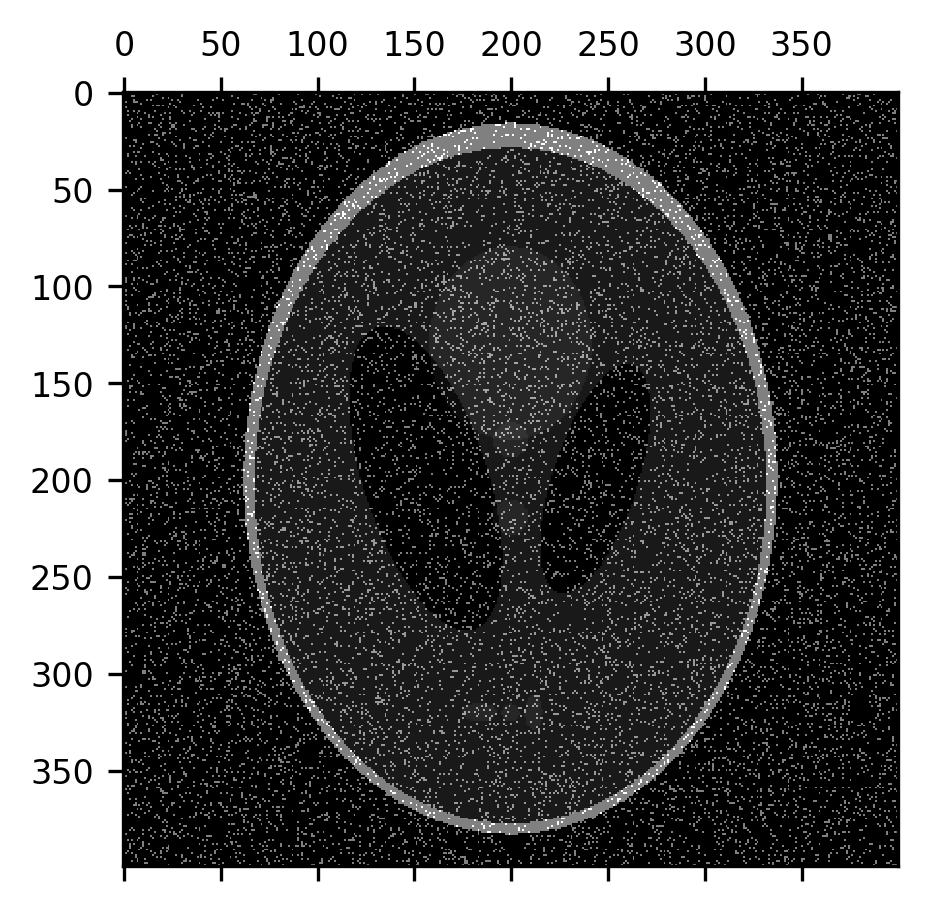

In [28]:
noise = np.random.rand(400, 400) < 0.1
fig, ax = plt.subplots()
im = ax.matshow(shepp_logan + noise)

An erosion operation can be used to remove this noise from the image because the
noise pixels are usually surrounded by pixels that have the correct value:

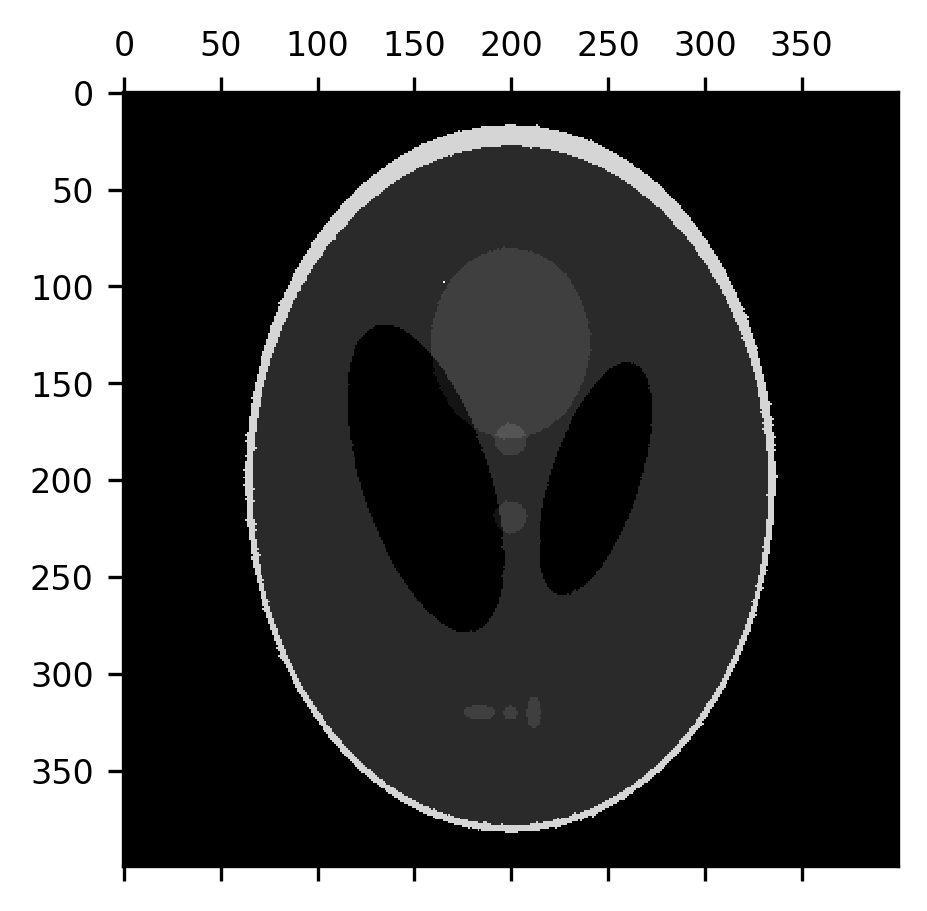

In [29]:
from skimage.morphology import erosion
fig, ax = plt.subplots()
im = ax.matshow(erosion(shepp_logan + noise))

This effectively removes the noise, but it also thins out the "skull" portion of
the image and the smaller elements within the image, while also slightly
expanding the size of the dark ventricles. Let's correct that by applying a
dilation to the eroded image. This recovers the image almost precisely as it was.

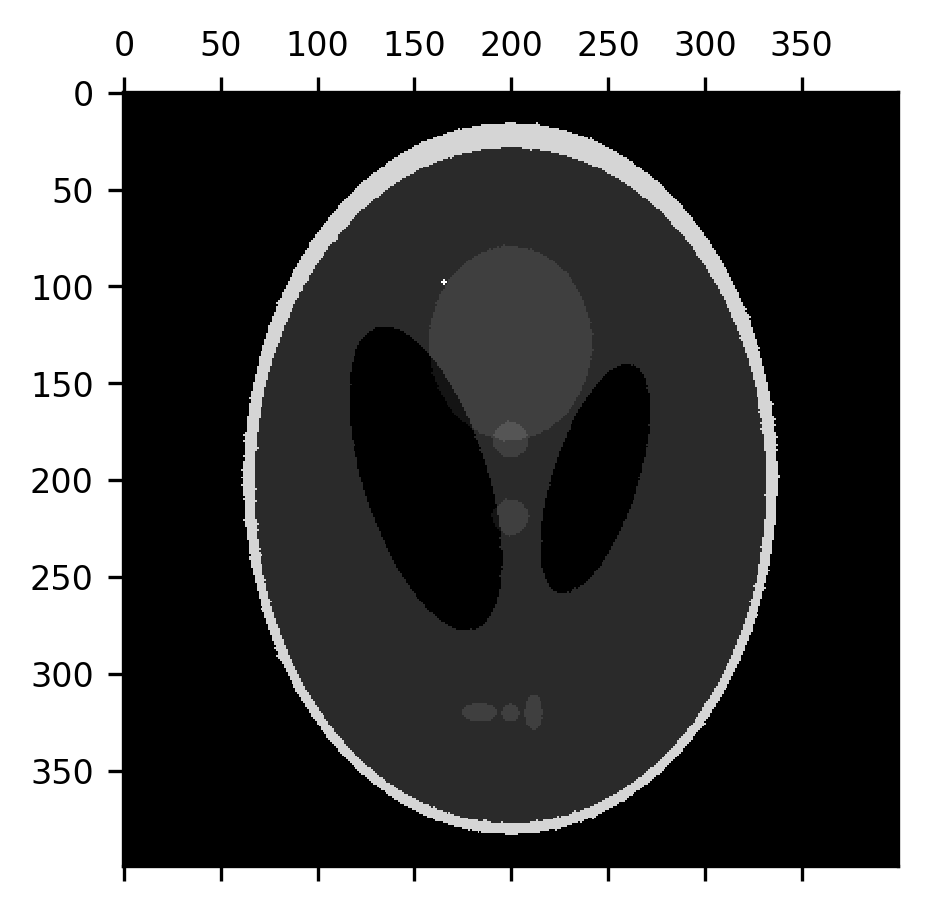

In [30]:
from skimage.morphology import dilation
fig, ax = plt.subplots()
im = ax.matshow(dilation(erosion(shepp_logan + noise)))

But the fact that the erosion removes a layer of pixels off of the boundaries
between different segments of the image can also be useful. For example, the
subtraction of the erosion from the original image can be used to detect the
edges between parts of the image.

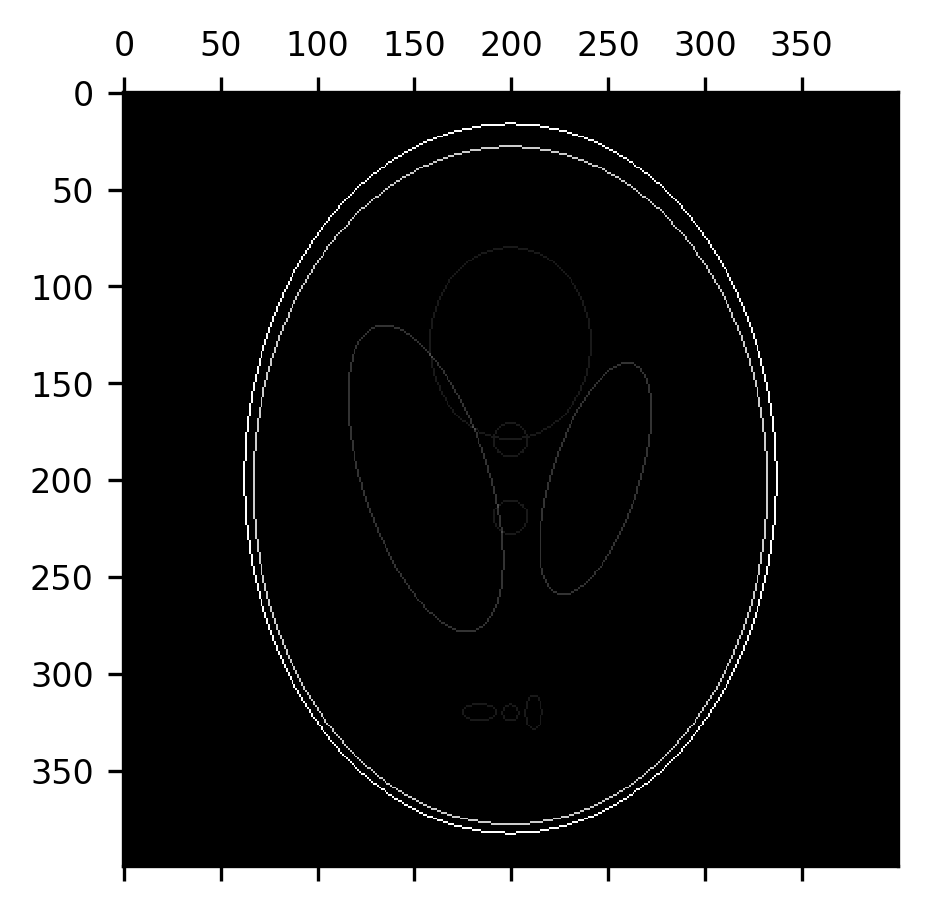

In [31]:
fig, ax = plt.subplots()
im = ax.matshow(shepp_logan - erosion(shepp_logan))

An erosion followed by a dilation is also called a *morphological opening*. This
can be used to remove most of the "skull" from this image, provided we use a
large enough structuring element. Here, we use a disk with a radius of 7 pixels.
Notice that this effectively removes the skull, while retaining the original
size of the ventricles, but some of the smaller elements in the image are also
eliminated along the way.

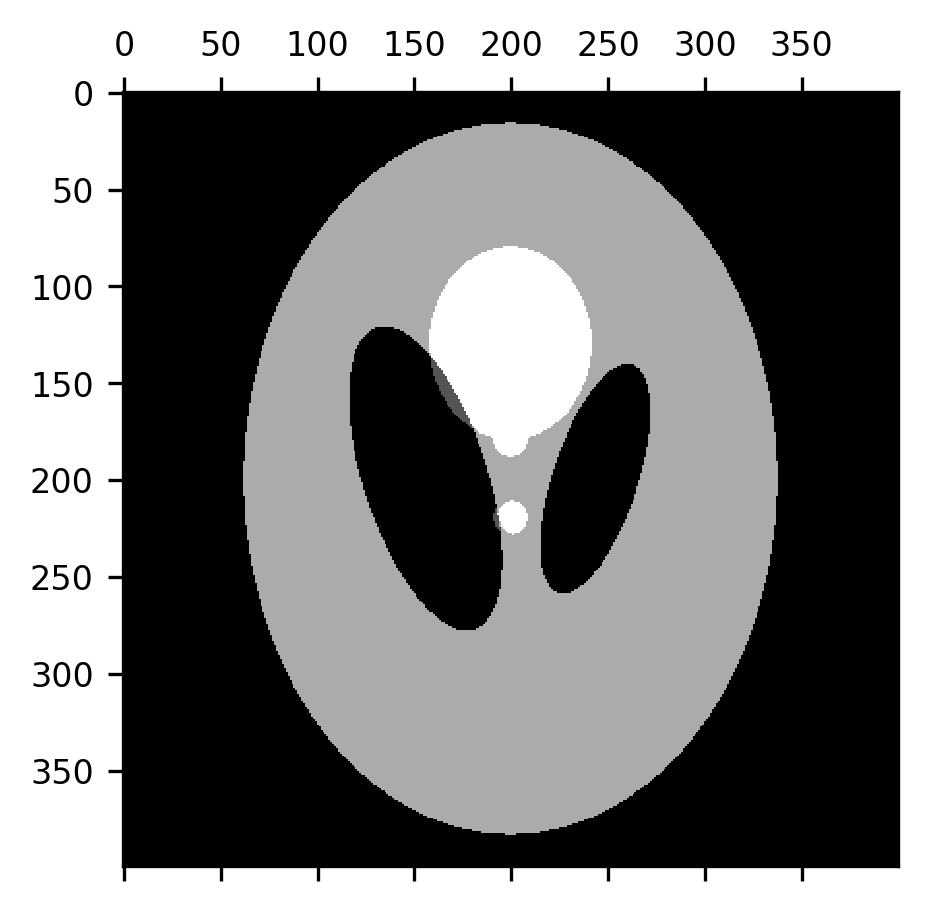

In [32]:
from skimage.morphology import disk
fig, ax = plt.subplots()
im = ax.matshow(dilation(erosion(shepp_logan, selem=disk(7)), selem=disk(7)))

A *morphological closing* is the exact opposite: a dilation followed by an
erosion. This tends to close the gaps between smaller elements in the image,
which can be useful in creating boundaries between different domains represented
in the image.

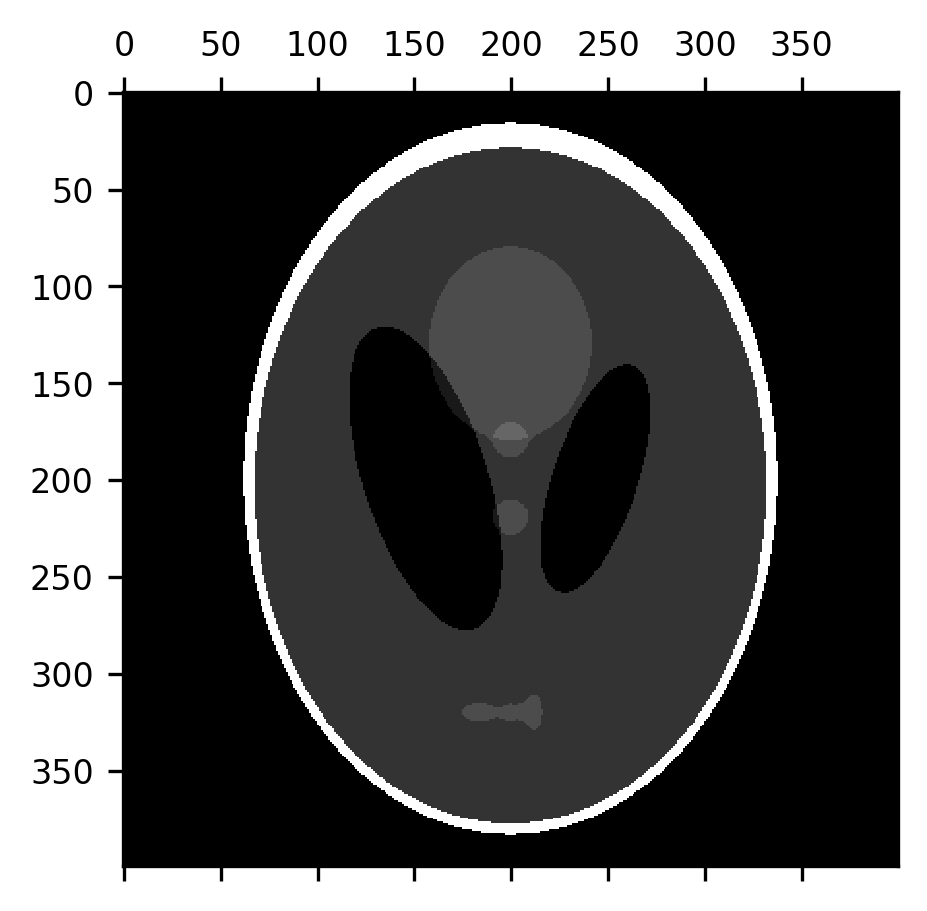

In [33]:
fig, ax = plt.subplots()
im = ax.matshow(erosion(dilation(shepp_logan, selem=disk(7)), selem=disk(7)))

(skimage_ex4)=
#### Exercises

1. A *morphological white tophat* is an image minus its morphological opening. A *morphological black tophat* is an image minus its morphological closing. Implement each of these as a function. What kinds of features do each of these emphasize? How does that depend on the structuring element that you use? Hint: `skimage.morphology` implements several structuring elements, including `disk` that you have already seen, but also `square`, `diamond` and others. Please consult the [Scikit Image documentation](https://scikit-image.org/docs/dev/auto_examples/numpy_operations/plot_structuring_elements.html) for more information.
2. Apply the morphological operations that you learned about to the brain slice image that we used to demonstrate Gaussian filtering with. Can you use these operations to remove the bits of skull that are apparent at the top of this slice? What do you lose when you do that? Can you do better by performing your morphological operations in 3D (Note: in 3D, you will need to use a three-dimensional structuring element, try `skimage.morphology.ball`)?

## Additional resources

The Scikit Image documentation contains detailed examples of many of the image processing operations that we discussed above, as well as many others. All of these examples can be executed directly from code that is provided in the [examples gallery](https://scikit-image.org/docs/stable/auto_examples/).